In [41]:
import pandas as pd
import vectorbt as vbt
from tqdm import tqdm
import matplotlib.pyplot as plt
import empyrical as ep
import requests
import numpy as np

import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [42]:
open = pd.read_csv('binance_usdt_futures_open.csv')
high = pd.read_csv('binance_usdt_futures_high.csv')
low = pd.read_csv('binance_usdt_futures_low.csv')
close = pd.read_csv('binance_usdt_futures_close.csv')
volume = pd.read_csv('binance_usdt_futures_volume.csv')

open['Open time'] = pd.to_datetime(open['Open time'])
open.set_index('Open time', inplace=True)

high['Open time'] = pd.to_datetime(high['Open time'])
high.set_index('Open time', inplace=True)

low['Open time'] = pd.to_datetime(low['Open time'])
low.set_index('Open time', inplace=True)

close['Open time'] = pd.to_datetime(close['Open time'])
close.set_index('Open time', inplace=True)

volume['Open time'] = pd.to_datetime(volume['Open time'])
volume.set_index('Open time', inplace=True)

### Getting a correlated pair

In [43]:
close.pct_change().corr()

,BTCUSDT,ETHUSDT,BCHUSDT,XRPUSDT,LTCUSDT,TRXUSDT,ETCUSDT,LINKUSDT,XLMUSDT,ADAUSDT,...,CTKUSDT,HAEDALUSDT,SXTUSDT,ASRUSDT,ALPINEUSDT,SYRUPUSDT,OGUSDT,NXPCUSDT,CVCUSDT,AWEUSDT
BTCUSDT,1.000000,0.779127,0.701691,0.574852,0.756319,0.569267,0.650867,0.601742,0.597705,0.680969,...,0.497871,0.946688,0.341592,0.362021,0.350394,0.196897,0.245987,0.108858,0.446074,0.961559
ETHUSDT,0.779127,1.000000,0.710614,0.626426,0.785857,0.614592,0.740884,0.687171,0.639598,0.738292,...,0.514951,0.874678,0.100479,0.366463,0.383500,0.227368,0.258427,0.075955,0.454061,0.897734
BCHUSDT,0.701691,0.710614,1.000000,0.548532,0.760913,0.543833,0.748663,0.641497,0.585632,0.602136,...,0.448149,0.649735,0.059974,0.346461,0.323561,0.271280,0.226532,0.369968,0.396559,0.686790
XRPUSDT,0.574852,0.626426,0.548532,1.000000,0.633078,0.534424,0.559901,0.537084,0.739853,0.641277,...,0.379109,0.996937,-0.032739,0.291288,0.311856,0.039040,0.201761,0.263663,0.375849,0.999595
LTCUSDT,0.756319,0.785857,0.760913,0.633078,1.000000,0.586464,0.717519,0.627589,0.642610,0.691852,...,0.493729,0.951944,-0.277852,0.362657,0.386377,0.168302,0.251267,0.453165,0.440762,0.966017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SYRUPUSDT,0.196897,0.227368,0.271280,0.039040,0.168302,0.273879,0.216259,0.245333,0.234510,0.201323,...,0.233395,0.664694,0.288786,0.176773,0.073901,1.000000,-0.274034,0.503796,0.224649,0.701081
OGUSDT,0.245987,0.258427,0.226532,0.201761,0.251267,0.178428,0.232955,0.255426,0.188241,0.222233,...,0.228704,0.979547,-0.176844,0.549505,0.447867,-0.274034,1.000000,0.274767,0.168279,0.968309
NXPCUSDT,0.108858,0.075955,0.369968,0.263663,0.453165,0.227996,0.233404,0.157238,0.264192,0.199058,...,0.315217,0.317041,0.057196,0.792444,0.214271,0.503796,0.274767,1.000000,0.141974,0.269410
CVCUSDT,0.446074,0.454061,0.396559,0.375849,0.440762,0.367805,0.407189,0.420807,0.373758,0.395345,...,0.329930,0.622214,0.165857,0.233422,0.322487,0.224649,0.168279,0.141974,1.000000,0.660433


### Selected pair : LTC/ETH

<Axes: xlabel='Open time'>

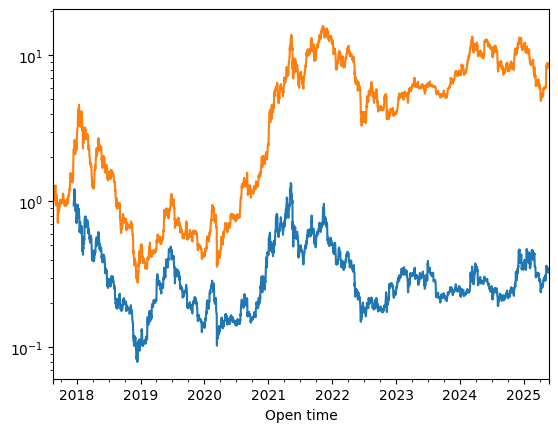

In [44]:
close['LTCUSDT'].pct_change().add(1).cumprod().plot(logy=True)
close['ETHUSDT'].pct_change().add(1).cumprod().plot()

### Backtesting a Simple Pairs System

1. Compute the spread, as the simple distance
2. Z-score the spread
3. Trade the z-score

In [59]:
def run_backtest(leg1, leg2):

    spread = close[leg1] - close[leg2]

    z = (spread - spread.rolling(14).mean().shift()) / spread.rolling(14).std().shift()

    entries = z > 3
    short_entries = z < -3
    exits = z.vbt.crossed_below(0)
    short_exits = z.vbt.crossed_above(0)

    pf_long = vbt.Portfolio.from_signals(
        close=open[leg1],
        entries=entries.shift().fillna(False),
        short_entries=short_entries.shift().fillna(False),
        exits=exits.shift().fillna(False),
        short_exits=short_exits.shift().fillna(False),
        fees=0.001
    )

    pf_short = vbt.Portfolio.from_signals(
        close=open[leg2],
        entries=short_entries.shift().fillna(False),
        short_entries=entries.shift().fillna(False),
        exits=short_exits.shift().fillna(False),
        short_exits=exits.shift().fillna(False),
        fees=0.001
    )

    pfreturns = pd.concat([pf_long.returns(), pf_short.returns()], axis=1).mean(axis=1)
    pfvalue = pfreturns.add(1).cumprod().mul(100)

    return pfreturns, pfvalue


In [64]:
leg1 = 'ETHUSDT'
leg2 = 'LTCUSDT'

pfreturns, pfvalue = run_backtest(leg1, leg2)

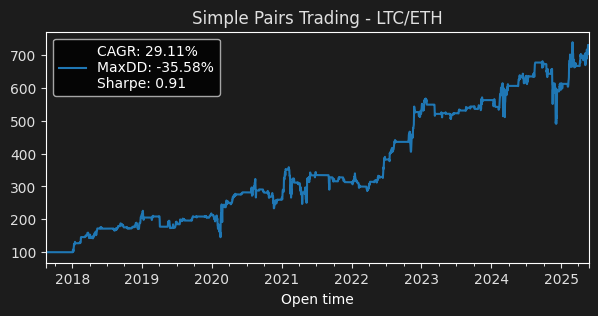

In [66]:
# Plotting results
CLR_BG     = "#1C1C1C"   # dark grey background
CLR_AX     = "#E0E0E0"   # light grey ticks/labels
plt.style.use('dark_background')
pfvalue.plot(color='#1f77b4', figsize=(7, 3))
plt.gca().set_facecolor(CLR_BG)
plt.gcf().set_facecolor(CLR_BG)
plt.legend().set_visible(False)
plt.title('Simple Pairs Trading - LTC/ETH', color=CLR_AX)
plt.tick_params(colors=CLR_AX)

# Calculate metrics
sharpe = round(ep.sharpe_ratio(pfreturns, annualization=365), 2)
cagr = round(ep.cagr(pfreturns, annualization=365) * 100, 2)
maxdd = round(ep.max_drawdown(pfreturns) * 100, 2)

# Add metrics to plot legend
plt.legend([f'CAGR: {cagr}%\nMaxDD: {maxdd}%\nSharpe: {sharpe}'])

# Save figure before showing
plt.savefig('./figures/simple_pairs_trading_ltc_eth.png', bbox_inches='tight', transparent=False, facecolor=CLR_BG)
plt.show()

### Next Steps

1. Better execution - use next day's close
2. Portfolio Construction - utilize rolling correlation to pick top correlated pairs dynamically, then trade them in a portfolio
3. Walk-forward parameter optimization and testing - select the N-day lookback for z-score, the entry/exit thresholds, along with the pairs to trade in a walk-forward setting